In [79]:
!sudo apt-get install mcl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  mcl-doc
The following NEW packages will be installed:
  mcl
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 627 kB of archives.
After this operation, 4852 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mcl amd64 1:14-137+ds-9build2 [627 kB]
Fetched 627 kB in 1s (883 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package mcl.
(Reading database ... 13635 files and directories currently installed.)
Preparing to unpack .../mcl_1%3a14-137+ds-9build2_amd64.deb ...
Unpacking mcl (1:14-137+ds-9build2) ...
Setting up mcl (1:14-137+ds-9build2) ...


In [170]:
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
fasttext_vocab = pickle.load(open('./preprocessed/attribute.token-freqs.fasttext.info.pickle', "rb"))
sbert_vocab = pickle.load(open('./preprocessed/attribute.token-freqs.sbert.info.pickle', "rb"))

In [52]:
vocab_df1 = pd.DataFrame(columns=['model', 'field', 'tokens', 'uniq_tokens', '%tokens_found', '%uniq_found'])
vocab_df2 = pd.DataFrame(columns=['model', 'field', 'measure', 'value'])
for m, d in [('fasttext', fasttext_vocab), ('sbert', sbert_vocab)]:
    for k, v in d.items():
        i1 = vocab_df1.index.size
        i2 = vocab_df2.index.size
        field = k
        tokens = v['tokens']
        uniq = v['uniq']
        oovt = v['oov_tokens']
        oovu = v['oov_uniq']
        pcntid = 100*(tokens-oovt)/tokens
        pcntuid = 100*(uniq-oovu)/uniq
        vocab_df1.loc[i1] = [m, field, tokens, uniq, pcntid, pcntuid]
        vocab_df2.loc[i2] = [m, field, '%tokens_found', pcntid]
        vocab_df2.loc[i2+1] = [m, field, '%uniq_found', pcntuid]
print('df1', vocab_df1.index.size, vocab_df1.head())
print('df2', vocab_df2.index.size, vocab_df2.head())

df1 84       model                                  field  tokens  uniq_tokens  \
0  fasttext                       bio_material_sam   13213         9629   
1  fasttext  biological_material_preprocessing_sam     306          115   
2  fasttext                   collection_label_sam    1511         1485   
3  fasttext                           comments_sam    2479         1015   
4  fasttext                       conductivity_sam      47           22   

   %tokens_found  %uniq_found  
0      27.798380     6.013085  
1      90.849673    80.000000  
2       3.309067     1.952862  
3      80.153288    55.665025  
4      87.234043    72.727273  
df2 168       model                                  field        measure      value
0  fasttext                       bio_material_sam  %tokens_found  27.798380
1  fasttext                       bio_material_sam    %uniq_found   6.013085
2  fasttext  biological_material_preprocessing_sam  %tokens_found  90.849673
3  fasttext  biological_material_p

In [53]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

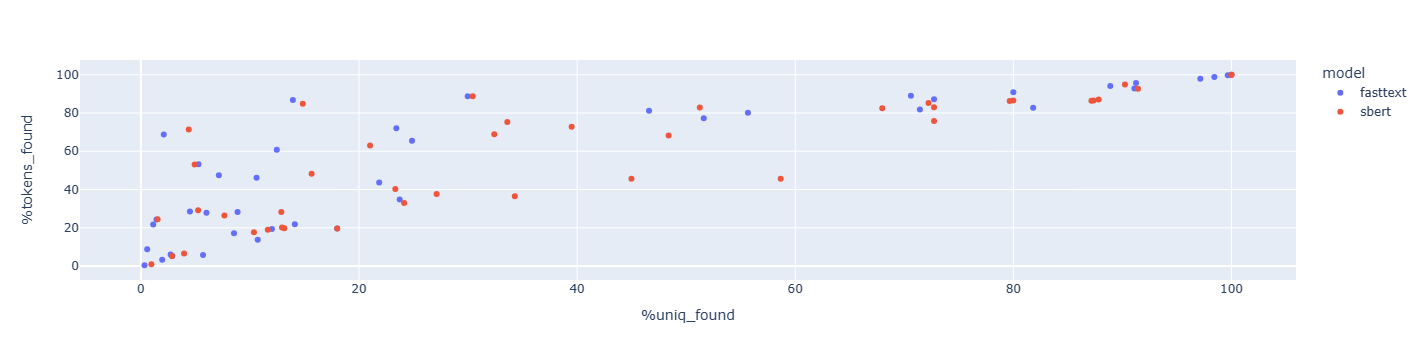

In [54]:
fig = px.scatter(vocab_df1, x='%uniq_found', y='%tokens_found', color='model', hover_data=['field', '%tokens_found', '%uniq_found'])
fig.show()

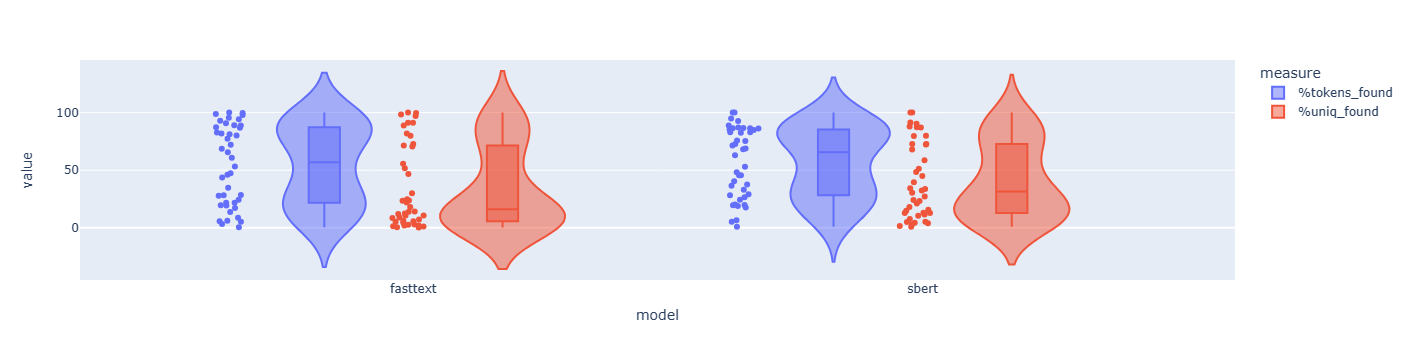

In [55]:
fig = px.violin(vocab_df2, y="value", x="model", color="measure", box=True, points="all",
          hover_data=vocab_df2.columns)
fig.show()

In [215]:
groupings_dict = {}
for a in vocab_df.field.unique():
    try:
        f = "./results/fasttext-similarity-matrix/fasttext-{attribute}.similarity-score-matrix.npy".format(attribute=a)
        test2_np = np.load(f)
        test2_np = np.nan_to_num(test2_np)
        test2 = pd.DataFrame(test2_np)
        test2_md = pd.read_csv("./attributes/{attributes}.entries.tsv".format(attribute=a), sep='\t', header=None)
        clustering = DBSCAN(eps=1+test2.quantile(q=1).quantile(q=1), min_samples=2).fit(test2_np)
        labels = clustering.labels_
        no_clusters = len(np.unique(labels) )
        no_noise = np.sum(np.array(labels) == -1, axis=0)
        test2['labels'] = labels
        test2 = test2[['labels']]
        for i in test2.index:
            test2.at[i, 'Value'] = test2_md[0].loc[i]
        groupings = [test2[test2.labels==i].Value.to_list() for i in test2.labels.unique()]
        groupings_dict.update({a: groupings})
        ss = silhouette_score(test2_np, labels)
        print(a)
        print(test2.max().max(), test2.min().min(), test2.mean().mean(), test2.quantile(q=0.5).quantile(q=0.5))
        print('Estimated no. of clusters: %d' % no_clusters)
        print('Estimated no. of noise points: %d' % no_noise)
        print(clustering)
        print('silhouette score:', ss)
    except:
        print(a, 'results not found at', "./results/fasttext-similarity-matrix/fasttext-{attribute}.similarity-score-matrix.npy".format(attribute=a))
        continue

bio_material_sam results not found at ./results/fasttext-similarity-matrix/fasttext-bio_material_sam.similarity-score-matrix.npy
biological_material_preprocessing_sam results not found at ./results/fasttext-similarity-matrix/fasttext-biological_material_preprocessing_sam.similarity-score-matrix.npy
collection_label_sam results not found at ./results/fasttext-similarity-matrix/fasttext-collection_label_sam.similarity-score-matrix.npy
comments_sam results not found at ./results/fasttext-similarity-matrix/fasttext-comments_sam.similarity-score-matrix.npy
conductivity_sam results not found at ./results/fasttext-similarity-matrix/fasttext-conductivity_sam.similarity-score-matrix.npy
corrected_species_name_sam results not found at ./results/fasttext-similarity-matrix/fasttext-corrected_species_name_sam.similarity-score-matrix.npy
coverage_sam results not found at ./results/fasttext-similarity-matrix/fasttext-coverage_sam.similarity-score-matrix.npy
date_of_birth_sam results not found at ./re

In [197]:
test2 = pd.DataFrame(np.load(f'./results/fasttext-similarity-matrix/fasttext-host_scietific_nam_sam.similarity-score-matrix.npy')).fillna(0)
test2_np = np.load(f'./results/fasttext-similarity-matrix/fasttext-host_scietific_nam_sam.similarity-score-matrix.npy')
test2_np = np.nan_to_num(test2_np)
test2_md = pd.read_csv(f'./attributes/host_scietific_nam_sam.entries.tsv', sep='\t', header=None)
print(test2.max().max(), test2.min().min(), test2.mean().mean(), test2.quantile(q=0.5).quantile(q=0.5))
#test2.head()

1.0000007 0.0 0.55982876 0.5921931564807892


In [198]:
clustering = DBSCAN(eps=1+test2.quantile(q=1).quantile(q=1), min_samples=2).fit(test2_np)
labels = clustering.labels_
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)
clustering

Estimated no. of clusters: 3
Estimated no. of noise points: 3


DBSCAN(eps=2.0000007152557373, min_samples=2)

In [199]:
test2['labels'] = labels
test2 = test2[['labels']]
for i in test2.index:
    test2.at[i, 'Value'] = test2_md[0].loc[i]
groupings = [test2[test2.labels==i].Value.to_list() for i in test2.labels.unique()]
for g in groupings:
    print(g)

['nestor notabilis', 'paroaria coronata', 'urocitellus parryii', 'tamandua tetradactyla', 'gallirallus australis greyi', 'apteryx australis mantelli', 'parahyaena brunnea', 'alouatta pigra', 'podargus strigoides', 'desmodus rotundus', 'bovicola caprae', 'ovis aries', 'cervus nippon', 'loxodonta africana', 'agelaius phoeniceus', 'lipoptena', 'casuarius casuarius', 'aceros corrugatus', 'rhea americana', 'geospiza difficilis septentrionalis', 'speothos venaticus', 'panthera onca', 'eudyptula minor minor', 'hypargos niveoguttatus', 'halcyon albiventris', 'buteo jamaicensis', 'empidomax minimus', 'camaroptera brachyura', 'shinisaurus crocodilurus', 'crocodylus rhombifer', 'strigops habroptilus', 'ammodramus maritimus', 'prionailurus viverrinus', 'hylomantis lemur or atelopus zeteki', 'phyllastrephus cerviniventris', 'struthio camelus', 'equus grevyi', 'tragulus napu', 'lemur catta', 'ninox novaeseelandiae', 'cercomela familiaris', 'anthropoides paradiseus', 'manis temmincki', 'tremarctos or

In [212]:
np.load('./results/fasttext-similarity-matrix/fasttext-biological_material_preprocessing_sam.similarity-score-matrix.npy')
np.load('./results/fasttext-similarity-matrix/fasttext-biological_material_preprocessing_sam.similarity-score-matrix.npy')

array([[1.0000006 , 0.92601496, 0.94068694, 0.9283609 , 0.2380612 ,
        0.9560834 , 0.9187934 ,        nan, 0.74370396,        nan,
        0.954122  , 0.7348614 , 0.7853339 , 0.74496216, 0.66705626,
        0.7427746 , 0.94222206],
       [0.92601496, 0.9999997 , 0.95199895, 0.97768366, 0.24184105,
        0.96407896, 0.9685608 ,        nan, 0.7800508 ,        nan,
        0.965302  , 0.77581817, 0.8183704 , 0.78567207, 0.67850286,
        0.7824694 , 0.9774198 ],
       [0.94068694, 0.95199895, 0.9999999 , 0.97851163, 0.25170478,
        0.96848816, 0.97256124,        nan, 0.7889791 ,        nan,
        0.97235715, 0.7865824 , 0.8186468 , 0.7905505 , 0.6901726 ,
        0.7930606 , 0.9777442 ],
       [0.9283609 , 0.97768366, 0.97851163, 0.99999994, 0.26091295,
        0.96530193, 0.98838645,        nan, 0.77667594,        nan,
        0.9654849 , 0.7791446 , 0.81923443, 0.78543156, 0.6908491 ,
        0.7854268 , 0.9593816 ],
       [0.2380612 , 0.24184105, 0.25170478, 0.260912